In [1]:
# 패키지 로드
import os
import numpy as np
import pandas as pd
# import pymysql
import requests
import math
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [3]:
# 라이엇 개발자 페이지에서 게임 상수 최신 버전 정보 가져오기
constant_patch = requests.get('https://ddragon.leagueoflegends.com/api/versions.json').json()[0]

# constant_patch == '11.22.1'

# 라이엇 개발자 페이지에서 최신 버전 한국 서버 아이템 정보 가져오기
item_info = requests.get('http://ddragon.leagueoflegends.com/cdn/'+constant_patch+'/data/ko_KR/item.json').json()

# 라이엇 개발자 페이지에서 최신 버전 한국 서버 챔피언 정보 가져오기
champion_info = requests.get('http://ddragon.leagueoflegends.com/cdn/'+constant_patch+'/data/ko_KR/champion.json').json()

# item_info, champion_info는 json형태

In [4]:
# 챔피언 정보 => DataFrame으로 변환
champion_df = pd.DataFrame(champion_info['data']).T[['key','name']]

# champion_df는 'key'로 id값, 'name'으로 챔피언 한국어 이름을 가지는 157rows짜리 DataFrame

# champion_df의 'key' column string => numeric 변환
champion_df['key'] = pd.to_numeric(champion_df['key'])

In [6]:
# 아이템 정보 => DataFrame으로 변환
item_df = pd.DataFrame(columns=['id','name','gold'])

# item_df는 아이템의 숫자 id, 한국어 이름(name) 및 조합비(직전 하위템 전부 갖고 있을 때 완성템을 조합할 때 드는 비용)를 가지는 DataFrame

item_tree = pd.DataFrame(columns=['id','id_from'])

# item_tree는 아이템의 숫자 id, 직전 하위템 리스트(id_from)를 가지는 DataFrame
# 예시: 유령 무희(2600G) = 롱소드(350G) + 열정의 검(1050G) + 롱소드(350G) + 850G이므로 유령 무희에 대한 rows가 3개 나옴

for item_id in item_info['data']:
    # Consumable한 아이템(체력 물약 등) 제외
    # 'tags'에 'Consumable' 정보가 없는 아이템에 대해서만 수행
    if 'Consumable' not in item_info['data'][item_id]['tags']:
        try:
            # 'consumed' 필드가 있는 아이템(부패 물약, 충전형 물약)은 하단 코드가 실행되지 않고 continue로 바로 다음 item_id로 넘어감
            item_info['data'][item_id]['consumed']
            continue
        except:
            pass
        
        # 아이템명 및 조합비
        # id, name, gold 3개 필드를 가지게끔 json parsing
        item_row = pd.json_normalize(item_info['data'][item_id])[['name','gold.base']]
        item_row['id'] = item_id
        item_row.rename(columns = {'gold.base':'gold'}, inplace = True)
        item_df = pd.concat([item_df,item_row])

        # 직전 하위템
        try:
            # 'from' 필드에 있는 항목을 각각 하나의 row로 가지는 item_row_tree DataFrame 생성
            item_row_tree = pd.json_normalize(item_info['data'][item_id],record_path=['from'])
            item_row_tree.rename(columns = {0:'id_from'},inplace=True)
            item_row_tree['id'] = item_id
            item_tree = pd.concat([item_tree,item_row_tree])
        # 하위템이 없는 경우 생략
        except Exception:
            pass

In [35]:
item_tree_full = item_tree
item_tree_new = item_tree

# 가장 하위 아이템까지 full 아이템트리 및 각 재료 아이템에 소모되는 골드를 item_tree_full DataFrame에 저장
# 예시로 이 셀 최종 시점에 유령 무희에 대해서는 다음과 같은 rows가 나옴
# id            | id_from          | gold
# 3046(유령 무희) | 3046(유령 무희)    | 850
# 3046(유령 무희) | 3086(열정의 검)    | 150
# 3046(유령 무희) | 1036(롱소드)       | 700
# 3046(유령 무희) | 1018(민첩성의 망토) | 600
# 3046(유령 무희) | 1042(단검)        | 300

while True:
    # item_tree_new에 item_tree를 merge해서 방금 추가한 하위템보다 한 depth 아래의 하위템 리스트 추출
    item_tree_new = item_tree_new.merge(item_tree, how = 'inner', left_on = 'id_from', right_on = 'id')\
    [['id_x','id_from_y']].\
    rename(columns = {'id_x':'id','id_from_y':'id_from'})
        
    # 모두 재료템만 남았으면 종료
    if len(item_tree_new) == 0:
        break
    item_tree_full = pd.concat([item_tree_full, item_tree_new])

# 자기자신을 리스트에 추가
item_tree_new['id']=item_df['id']
item_tree_new['id_from']=item_df['id']
item_tree_full = pd.concat([item_tree_full, item_tree_new])

In [36]:
# 각 아이템의 조합비를 merge
item_tree_full = item_tree_full.merge(item_df, left_on = 'id_from', right_on = 'id')[['id_x','id_from','gold']].\
rename(columns = {'id_x':'id'})

# 중복되는 row가 발생할 시 gold 수치를 합쳐서 중복되는 row 제거
item_tree_full = item_tree_full.groupby(['id','id_from'], as_index=False).sum(['gold'])

# 유령 무희 | 롱소드 | 350
# 유령 무희 | 롱소드 | 350
# -->
# 유령 무희 | 롱소드 | 700

In [40]:
# string => numeric 형변환
item_df['id'] = pd.to_numeric(item_df['id'])
item_tree_full['id'] = pd.to_numeric(item_tree_full['id'])
item_tree_full['id_from'] = pd.to_numeric(item_tree_full['id_from'])

In [43]:
# 메모리 확보를 위해 사용하지 않을 변수 삭제
del constant_patch
del champion_info
del item_id
del item_info
del item_row
del item_row_tree
del item_tree
del item_tree_new

In [ ]:
# # OPGG Database에 connection 생성
# con = pymysql.connect(
#     user = os.environ['LOL_KR_ID'],
#     passwd = os.environ['LOL_KR_PW'],
#     host = os.environ['LOL_KR_HOST'],
#     db = 'lol',
#     charset = 'utf8'
# )
# cursor = con.cursor(pymysql.cursors.DictCursor)

In [ ]:
# # 패치 날짜 데이터 불러오기
# cursor.execute('''
# SELECT version, date
# FROM lolVersionHistory
# ''')
# patchDate = cursor.fetchall()

# patchDate = pd.DataFrame(patchDate)

# # version => season, patch로 가공, 세부 버전(핫픽스, 밸런싱 X 패치 등) 제거
# patchDate['season'] = pd.to_numeric(patchDate['version'].str.split('.').str[0])
# patchDate['patch'] = pd.to_numeric(patchDate['version'].str.split('.').str[1])
# patchDate = patchDate.groupby(['season','patch'],as_index=False).min('date').drop('version', axis = 1).sort_values(['season','patch'])

In [ ]:
# # 현재 패치 칼바람 챔피언&아이템 데이터 불러오기
# cursor.execute('''
# SELECT STRAIGHT_JOIN championId, item0, item1, item2, item3, item4, item5
# FROM opGame o FORCE INDEX (ix_createDate),
# p_opGameStats p FORCE INDEX (`PRIMARY`)
# WHERE o.gameId = p.gameId
# AND o.createDate >= '{lastpatch}'
# AND p.createDate >= '{lastpatch}'
# AND subType = 450
# '''.format(lastpatch=pd.to_datetime(patchDate['date'].tail(1).values[0])))
# gamestats = cursor.fetchall()

# gamestats = pd.DataFrame(gamestats)

# # # csv로 저장
# # gamestats.to_csv("gamestats.csv", mode='w')

In [44]:
# csv 파일에서 가져오기
gamestats = pd.read_csv('gamestats.csv', index_col=0)

/usr/local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [46]:
gamestats

,championId,item0,item1,item2,item3,item4,item5
0,145,6655,3020,4628,0,0,0
1,42,3042,6670,3020,2031,1053,0
2,45,6655,3020,3165,0,0,0
3,236,0,0,0,6670,1037,3006
4,103,6655,3020,3916,1058,0,0
...,...,...,...,...,...,...,...
8987535,161,6655,3102,3135,4637,1026,1052
8987536,117,6617,3040,3158,6616,3011,0
8987537,103,6655,4628,4629,3020,1026,4630
8987538,246,6691,3142,3156,6695,6694,3158


In [47]:
# 아이템 컬럼 하나로 모으기
# 'pandas.melt'라는 함수를 적용
# gamestats에 item0 ~ item5로 나와있는 컬럼을 item 컬럼으로 합쳐서 한 소환사당 1*6 형태로 된 DataFrame을 6*1로 변환
itemstats = pd.melt(gamestats, id_vars = 'championId', value_name = 'item').drop('variable', axis =1)

# itemstats에는 챔피언id가 'championId'로, 구매한 아이템이 'item' column으로 들어감

# 빈 값(0) 지우기
itemstats = itemstats[itemstats.item != 0]

In [49]:
del gamestats

In [50]:
# 약간 신비한 신발 => 신발 치환
itemstats.item[itemstats.item == 2422] = 1001

# 초시계 시리즈 => 초시계 치환
itemstats.item[itemstats.item.isin([2419, 2421, 2423, 2424])] = 2420

# 무라마나 => 마나무네 치환
# 대천사의 포옹 => 대천사의 지팡이 치환
itemstats.item[itemstats.item == 3042] = 3004
itemstats.item[itemstats.item == 3040] = 3003

# 오른의 걸작 치환
itemstats.item[itemstats.item == 7000] = 6693
itemstats.item[itemstats.item == 7001] = 6692
itemstats.item[itemstats.item == 7002] = 6691
itemstats.item[itemstats.item == 7003] = 6664
itemstats.item[itemstats.item == 7004] = 3068
itemstats.item[itemstats.item == 7005] = 6662
itemstats.item[itemstats.item == 7006] = 6671
itemstats.item[itemstats.item == 7007] = 6672
itemstats.item[itemstats.item == 7008] = 6673
itemstats.item[itemstats.item == 7009] = 4633
itemstats.item[itemstats.item == 7010] = 4636
itemstats.item[itemstats.item == 7011] = 3152
itemstats.item[itemstats.item == 7012] = 6653
itemstats.item[itemstats.item == 7013] = 6655
itemstats.item[itemstats.item == 7014] = 6656
itemstats.item[itemstats.item == 7015] = 6630
itemstats.item[itemstats.item == 7016] = 6631
itemstats.item[itemstats.item == 7017] = 6632
itemstats.item[itemstats.item == 7018] = 3078
itemstats.item[itemstats.item == 7019] = 3190
itemstats.item[itemstats.item == 7020] = 2065
itemstats.item[itemstats.item == 7021] = 6617
itemstats.item[itemstats.item == 7022] = 4005

In [ ]:
# 챔피언별로 각 아이템에 투자한 골드 총량 계산

# championId, item를 기준으로 grouping하여 row 수를 'size' column을 만들어 저장
itemstats = itemstats.groupby(['championId','item'], as_index=False).size()

# item_tree_full과 merge하여 각 아이템에 맵핑되는 조합비(gold) column 추가
itemstats = itemstats.merge(item_tree_full, left_on = 'item', right_on = 'id')[['championId','id_from','gold','size']]

# 해당 아이템의 조합비가 적혀 있는 'gold' column에 해당 아이템을 사는데 소모한 총 골드(gold * size) 덮어쓰기
itemstats['gold'] = itemstats['gold'] * itemstats['size']

# 이후 계산 알아보기 쉽도록 scaling
# Consine similarity를 쓰기 때문에 value scaling은 영향 없음
itemstats['gold'] = itemstats['gold'] / 1e5

# size column 제거
itemstats = itemstats.drop('size',axis=1)

# item_tree_full과 merge할 때 생긴 중복 row 합치기
itemstats = itemstats.groupby(['championId','id_from'],as_index=False).apply(lambda x: pd.Series({'gold':
                                                                                         sum(x.gold)}))

In [74]:
# 챔피언 골드 비례 상수 계산
championstats = itemstats.groupby('championId',as_index=False).apply(lambda x: pd.Series({'length':
                                                                                         math.sqrt(sum(x.gold**2))}))

In [75]:
# 각 챔피언 간 유사도 계산을 위한 내적(inner product) 계산 수행

# itemstats 자기자신을 아이템 기준으로 merge하여 champion X와 champion Y가 해당 아이템을 사는데 소모한 골드를 한 row에 저장
itemstats = itemstats.merge(itemstats, on = 'id_from')[['championId_x','championId_y','gold_x','gold_y']]
# itemstats == [championId_x | championId_y | gold_x | gold_y]

# championId_x > championId_y인 row만 남기기
itemstats = itemstats[itemstats.championId_x > itemstats.championId_y]

In [77]:
# 각 row에 대해 gold_x와 gold_y를 곱해서 gold_prod 컬럼에 저장
itemstats['gold_prod'] = itemstats['gold_x'] * itemstats['gold_y']

# 다 사용한 gold columns 제거
itemstats = itemstats.drop(['gold_x','gold_y'],axis=1)

# championId_x, championId_y를 기준으로 grouping하여 gold_prod 합 계산
itemstats = itemstats.groupby(['championId_x','championId_y'],as_index=False).\
apply(lambda x:pd.Series({'gold_prod':sum(x.gold_prod)}))
# itemstats == [championId_x | championId_y | gold_prod]

In [81]:
# 챔피언 유사도 및 거리 계산

# itemstats에 championstats를 merge해서 length_x, length_y 컬럼 추가
itemstats = itemstats.merge(championstats, left_on = 'championId_x', right_on = 'championId').drop('championId',axis=1)
itemstats = itemstats.merge(championstats, left_on = 'championId_y', right_on = 'championId').drop('championId',axis=1)
# itemstats == [championId_x | championId_y | gold_prod | length_x | length_y]

In [83]:
# similarity = gold_prod / (length_x * length_y) column 추가
itemstats['similarity'] = itemstats['gold_prod'] / (itemstats['length_x']*itemstats['length_y'])

In [86]:
itemstats[itemstats.championId_x == 222].sort_values('similarity')

,championId_x,championId_y,gold_prod,length_x,length_y,similarity
7841,222,69,1.923949e+04,4015.482002,1107.675736,0.004326
9656,222,101,1.104004e+05,4015.482002,3366.854668,0.008166
4211,222,30,1.037881e+05,4015.482002,2876.410198,0.008986
9584,222,99,1.693443e+05,4015.482002,4455.186738,0.009466
7747,222,68,1.226115e+05,4015.482002,3109.820459,0.009819
...,...,...,...,...,...,...
10937,222,133,6.811448e+06,4015.482002,1799.083067,0.942867
4084,222,29,1.148184e+07,4015.482002,2986.161333,0.957548
6326,222,51,1.562073e+07,4015.482002,4039.195986,0.963094
11651,222,203,5.233912e+06,4015.482002,1344.093763,0.969749


In [88]:
# distance = arccos(similarity)/(pi/2) column 추가
itemstats['distance'] = np.arccos(itemstats['similarity'])/(math.pi/2)

In [90]:
# 필요한 column(챔피언간 거리)만 추출
itemstats = itemstats[['championId_x','championId_y','distance']]

In [92]:
# distance array 형태로 변환
# index에 주의

# itemstats를 championId_x, championId_y 내림차순으로 정렬하여 'distance' column만 남겨두기
distance_array = itemstats.sort_values(['championId_x','championId_y'], ascending=[False,False])['distance']

In [94]:
# 'complete' 메소드로 h-clustering 수행
Z = linkage(distance_array, 'complete')

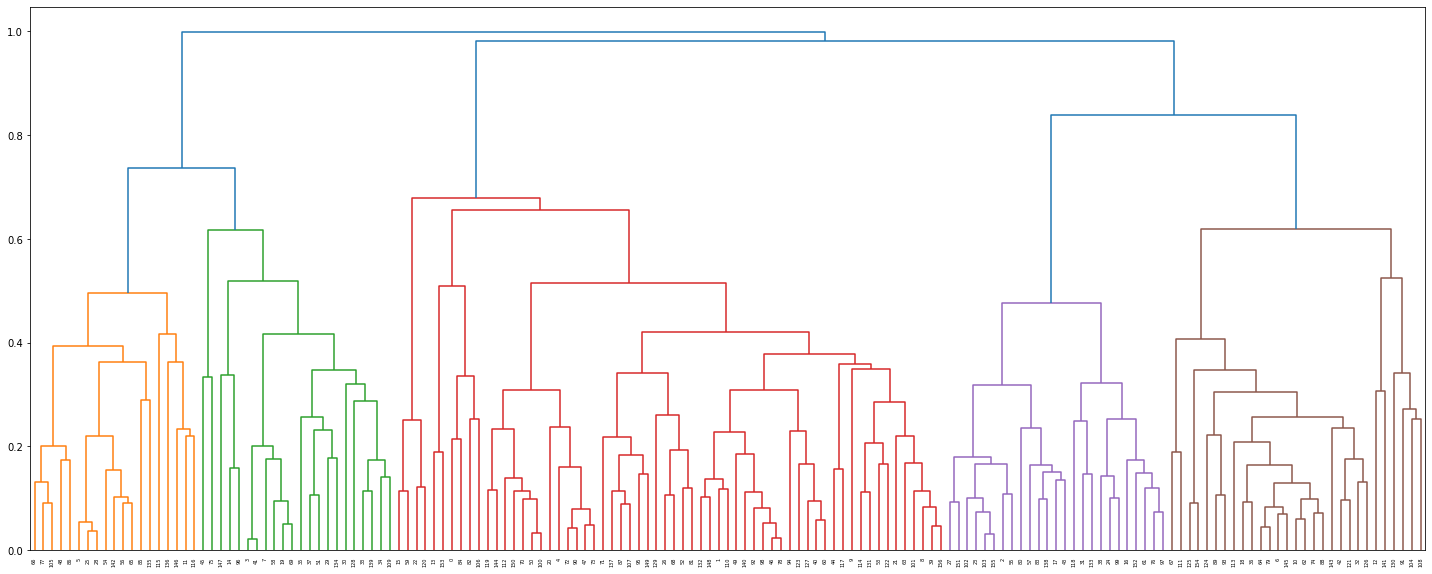

In [95]:
# 시각화
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [107]:
# 적당한 개수의 클러스터로 구분
cluster = pd.DataFrame(fcluster(Z,0.6,criterion='distance'))
cluster.columns=['cluster']

In [108]:
# 결과 DataFrame 구성

# key column 기준 내림차순으로 된 champion_df.name를 cluster 오른쪽에 concat
result = pd.concat([cluster,champion_df.sort_values('key',ascending=False)['name'].reset_index(drop=True)],axis=1)
# result == [cluster | name]

In [109]:
# 출력
pd.set_option('display.max_rows', None)
result.sort_values('cluster')

,cluster,name
77,1,탈론
115,1,코르키
116,1,갱플랭크
54,1,제이스
105,1,녹턴
56,1,카직스
28,1,제드
25,1,키아나
135,1,애쉬
136,1,미스 포츈
